## Importing libraries

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr
import numpy as np
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.simplefilter('ignore')
from lifelines import KaplanMeierFitter

## Reading csv files

In [25]:
reads = pd.read_csv('../summary_data/summary_tcga_reads.csv')
vj = pd.read_csv('../summary_data/summary_tcga_VJ.csv')
cdr3 = pd.read_csv('../summary_data/summary_tcga_cdr3.csv')
microbiome = pd.read_csv('../summary_data/summary_tcga_microbiome.csv')
mtDNA = pd.read_csv('../summary_data/summary_tcga_mtDNA.csv')
purity = pd.read_csv('../summary_data/purity.csv')
purity = purity.dropna(subset=['CPE'])
tcga_cdr = pd.read_csv('../summary_data/TCGA-CDR.csv')

## Joining data into single dataframe

In [26]:
sbt = cdr3.merge(vj, left_on='sample', right_on='sample', suffixes=('', 'vj'))
sbt = sbt.merge(microbiome, left_on='sample', right_on='sample', suffixes=(False, False))
sbt = sbt.merge(mtDNA, left_on='sample', right_on='sample', suffixes=(False, False))
sbt = sbt.merge(reads, left_on='sample', right_on='sample', suffixes=(False, False))
sbt['FileID'] = sbt['sample'].str[:36]


metadata = pd.read_csv('../summary_data/explore_case_table.tsv', delimiter="\t")
metadata = metadata.merge(pd.read_csv('../summary_data/gdc_sample_sheet.tsv', delimiter="\t"), left_on='Case ID', right_on='Case ID', suffixes=(False, False))
metadata['FileID'] = metadata['File Name'].str[:36]
metadata = metadata[['FileID', 'Case ID', 'Sample ID']]


data = metadata.merge(sbt, left_on='FileID', right_on='FileID', suffixes=(False, False))
data = data.merge(tcga_cdr, left_on='Case ID', right_on='bcr_patient_barcode', suffixes=(False, False))
data_with_purity = data.merge(purity, left_on='Sample ID', right_on='Sample ID', suffixes=(False, False))

data_with_purity['Age'] = data_with_purity['age_at_initial_pathologic_diagnosis']
sbt = sbt.drop(columns=['n_unique_pe'])
sbt = sbt.drop(columns=['name'])
sbt = sbt.drop(columns=['mtDNA_ID'])
sbt = sbt.drop(columns=['FileID'])
data_with_purity['Sex'] = data_with_purity['gender'] == "FEMALE"
data_with_purity = data_with_purity.dropna(subset=['Age'])


## Average of female samples

In [28]:
np.mean(data_with_purity['Sex'])

0.5384615384615384

## Linear model for SBT features 

In [29]:
X = data_with_purity[['Sex', 'Age','n_unique_pe','CPE']]
X['Sex'] = X['Sex'].astype(int)

X = np.array(X)
X = sm.add_constant(X)

pvalues = []
for i in range(1,len(sbt.columns)):
    y = data_with_purity[sbt.columns[i]]
    y = np.array(y)
    mod = sm.OLS(y,X)
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    pvalues.append([sbt.columns[i],p_values[1:]['x1'],p_values[1:]['x2'],p_values[1:]['x3'],p_values[1:]['x4']])

pvalues = pd.DataFrame(pvalues)   
pvalues.columns = ['feature','gender','age','#reads','purity']
pvalues.round(4)

,feature,gender,age,#reads,purity
0,nIGH,0.9378,0.8402,0.0000,0.0000
1,nIGK,0.1697,0.7334,0.0000,0.0000
2,nIGL,0.5738,0.9426,0.0000,0.0000
3,nTCRA,0.2951,0.1238,0.0000,0.0000
4,nTCRB,0.4097,0.1563,0.0000,0.0000
5,nTCRD,0.2372,0.5499,0.0000,0.0000
6,nTCRG,0.5731,0.2843,0.0000,0.0000
7,loadIGH,0.1469,0.5531,0.0014,0.0000
8,loadIGK,0.2641,0.9419,0.0000,0.0000
9,loadIGL,0.1680,0.9750,0.0001,0.0000


# Cox regression for alphaTCRG

In [57]:
from lifelines import CoxPHFitter

time_ = 'OS.time'
event_ = 'OS'
feature = 'alphaTCRG'
    
data_ = data_with_purity[[time_, event_, feature]]

data_['non-zero_alphaTCRG'] = data_['alphaTCRG'] > 0
data_['non-zero_alphaTCRG']  = data_['non-zero_alphaTCRG'].astype(int)

data_ = data_[[time_, event_, 'non-zero_alphaTCRG']]

cph = CoxPHFitter()
cph.fit(data_, duration_col=time_, event_col=event_)
cph.print_summary()


# Kaplan Meyer fit

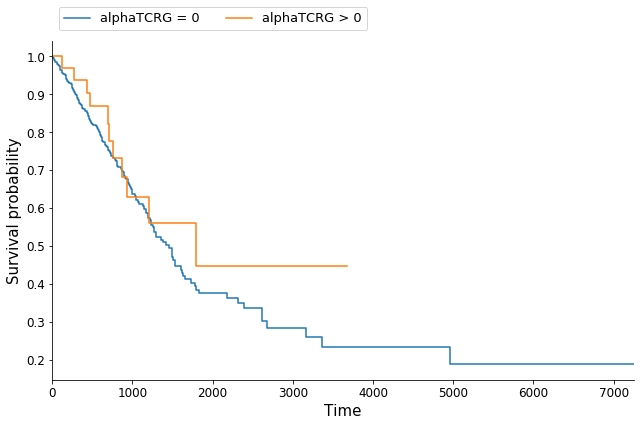

In [59]:

df0 = data_.loc[data_['non-zero_alphaTCRG'] == 0] 
df1 = data_.loc[data_['non-zero_alphaTCRG'] == 1] 

import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


fig, ax = plt.subplots(figsize=(9, 6))

kmf = KaplanMeierFitter()
kmf.fit( df0[time_],df0[event_], label=feature+" = 0")
kmf.plot(ci_show=False)
kmf.fit( df1[time_],df1[event_], label=feature+" > 0")
kmf.plot(ci_show=False)

plt.legend(bbox_to_anchor=(0,.92,1,0.2), loc="upper left", prop={'size': 13},  ncol=3)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.ylabel('Survival probability', fontsize=15)
plt.xlabel('Time', fontsize=15)
#plt.xlim(0,3000)
plt.tight_layout()
